In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src")
from main import Country

ERROR 1: PROJ: proj_create_from_database: Open of /home/simon/miniforge3/envs/Population-Loss-NW/share/proj failed


In [9]:
# country that is attacked
country_name = "France" 

# nuclear arsenal with which the country is attacked (number of warheads and yield in kt)
# arsenal = 200*[100] 
arsenal = 50*[15]

In [3]:
country = Country(country_name, landscan_year=2022)

# sanity check - this corresponds to the population of the selected country
country.data.sum() 

LandScan TIF file loaded successfully.


64859063

In [10]:
country.attack_max_fatality_non_overlapping(arsenal, include_injuries=True)

In [11]:
country.get_total_fatalities()

5855212


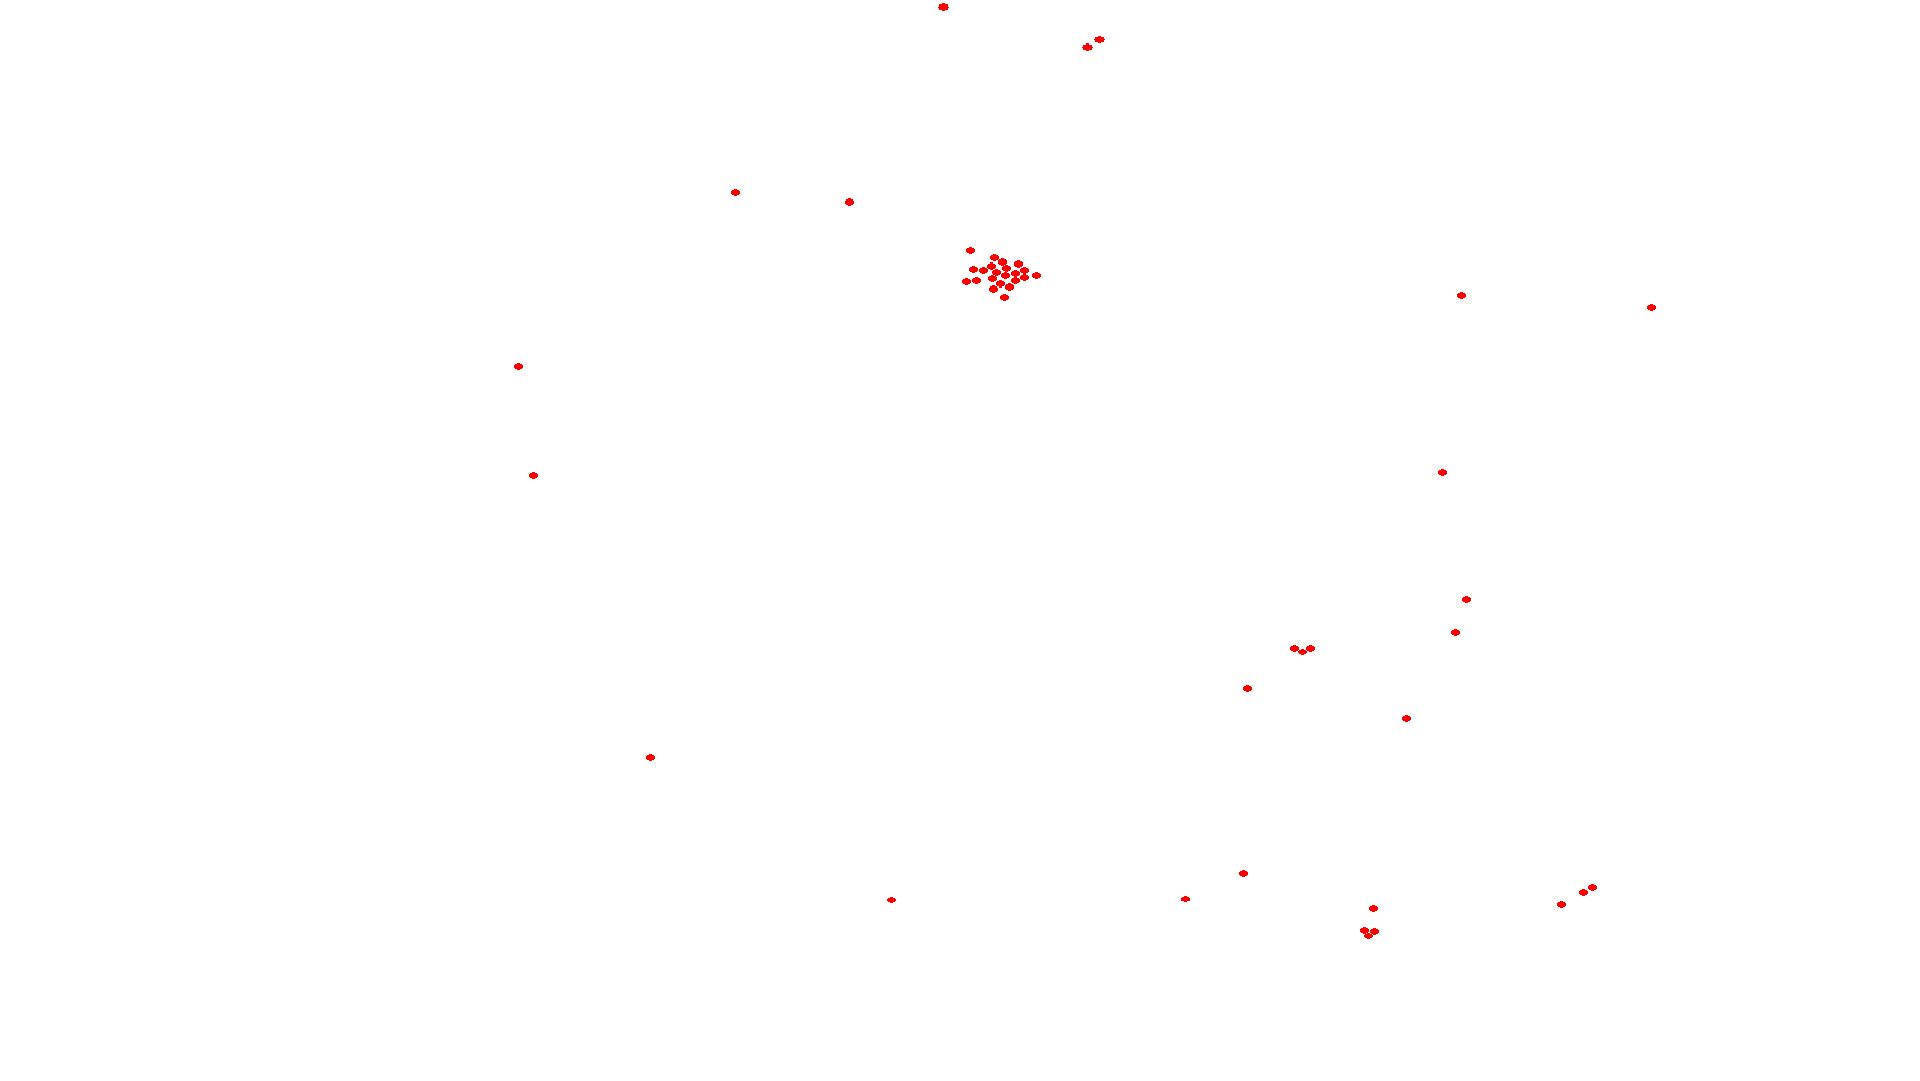

In [12]:
m = country.plot(show_hit_regions=True, show_population_density=False)
m